# Housing price modeling

Elias Eskelinen, Vili Niemelä, Matti Aalto and Jarkko Komulainen

---

In this project, a model to predict the house-prices of the five major metropolitan areas in U.S. is implemented. The corresponding five major metropolitan areas are New York, Chicago, Los Angeles, Philadelphia, and Washington. The data of this project is HouseTS dataset which can be found from.

## Data onboarding

Fetch the data from the kaggle API (saved as a local file)

In [28]:
import os
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt

In [ ]:
# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("shengkunwang/housets-dataset")
data_path = os.path.join(data_dir, "HouseTS.csv");

Load the data from the local file

In [30]:
data = pd.read_csv(data_path)
print(data.shape)
print(data.head())
print(data.info())

(884092, 39)
         date  median_sale_price  median_list_price  median_ppsf  \
0  2012-03-31            46550.0           217450.0    31.813674   
1  2012-04-30            61870.0           245000.0    40.723982   
2  2012-05-31           125500.0           217450.0    63.913043   
3  2012-06-30           153000.0           189900.0    81.598080   
4  2012-07-31           165500.0           154000.0    81.598080   

   median_list_ppsf  homes_sold  pending_sales  new_listings  inventory  \
0        110.183666        14.0           23.0          44.0       64.0   
1        130.528256        22.0           29.0          56.0       69.0   
2        119.919216        24.0           40.0          63.0       60.0   
3        105.617353        34.0           46.0          50.0       57.0   
4         83.921175        39.0           49.0          42.0       50.0   

   median_dom  ...  Total Housing Units  Median Rent  Median Home Value  \
0        59.5  ...               2677.0        710.0

Format `date` column as `datetime` and set the `date` column as the dataset index

In [31]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

---

## Data visualization and exploratory analysis

The time-series dataset consists of 884092 samples with 39 variables. The samples are monthly observations of housingThe predicted variable is `price`; the predictors are all numerical data, except for the `date` variable and the categorical variable `city_full`. 

---

## Time-series decomposition analysis

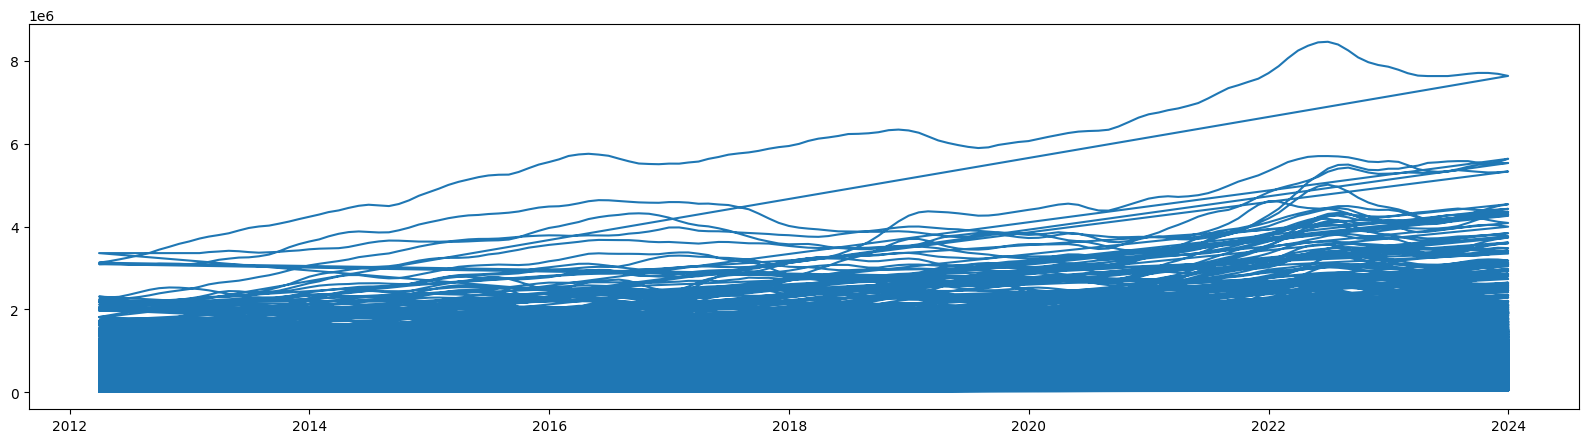

In [32]:
plt.figure(figsize=(20,5))
plt.plot(data["price"])
plt.show()

---

## Autocorrelation analysis

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 884092 entries, 2012-03-31 to 2023-12-31
Data columns (total 38 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   median_sale_price             884092 non-null  float64
 1   median_list_price             884092 non-null  float64
 2   median_ppsf                   884092 non-null  float64
 3   median_list_ppsf              884092 non-null  float64
 4   homes_sold                    884092 non-null  float64
 5   pending_sales                 884092 non-null  float64
 6   new_listings                  884092 non-null  float64
 7   inventory                     884092 non-null  float64
 8   median_dom                    884092 non-null  float64
 9   avg_sale_to_list              884092 non-null  float64
 10  sold_above_list               884092 non-null  float64
 11  off_market_in_two_weeks       884092 non-null  float64
 12  city                        

---

## Partitioning the time-series data